In [66]:
import crowsetta
import hdf5storage
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
data_path = r'C:\Users\Sivan\Desktop\MSc\Cohen Lab\Data\lb4444_1_annotation_July_2019_Vika.mat'

In [22]:
mat_file = hdf5storage.loadmat(data_path)
mat_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Jun 28 14:06:01 2022',
 '__version__': '1.0',
 '__globals__': [],
 'keys': array([[array(['lb4444_00001_2019_05_21_10_52_58.wav'], dtype='<U36'),
         array(['lb4444_00002_2019_05_21_10_52_58.wav'], dtype='<U36'),
         array(['lb4444_00003_2019_05_21_10_52_58.wav'], dtype='<U36'),
         ...,
         array(['lb4444_03926_2019_06_09_14_27_28.wav'], dtype='<U36'),
         array(['lb4444_03927_2019_06_09_15_18_48.wav'], dtype='<U36'),
         array(['lb4444_03928_2019_06_09_16_35_48.wav'], dtype='<U36')]],
       dtype=object),
 'elements': array([[array([[(array([[(array(['lb4444'], dtype='<U6'), array(['Recording from Canary'], dtype='<U21'), array([[44100]], dtype=uint16), array([[0]], dtype=uint8), array([], shape=(0, 0), dtype=uint8), array(['13-Jun-2019'], dtype='<U11'), array(['YC'], dtype='<U2'))]],
                       dtype=[('birdname', 'O'), ('expername', 'O'), ('desiredInSampRate', 'O'), ('

In [23]:
scribe = crowsetta.Transcriber(format='yarden')

In [26]:
audseqs = []

In [27]:
audseqs.append(scribe.from_file(data_path))

In [31]:
audseqs[0][0]

Annotation(annot_path=WindowsPath('C:/Users/Sivan/Desktop/MSc/Cohen Lab/Data/lb4444_1_annotation_July_2019_Vika.mat'), audio_path=WindowsPath('lb4444_00001_2019_05_21_10_52_58.wav'), seq=<Sequence with 126 segments>)

In [69]:
audseqs[0][1]

Annotation(annot_path=WindowsPath('C:/Users/Sivan/Desktop/MSc/Cohen Lab/Data/lb4444_1_annotation_July_2019_Vika.mat'), audio_path=WindowsPath('lb4444_00002_2019_05_21_10_52_58.wav'), seq=<Sequence with 401 segments>)

In [49]:
str(example_annot.audio_path)

'lb4444_00001_2019_05_21_10_52_58.wav'

In [52]:
records = []
for annot in audseqs[0]:
    curr_path = str(annot.audio_path)
    for segment in annot.seq.segments:
        records.append(
            {
                'path': curr_path,
                'label': segment.label,
                'duration': segment.offset_s - segment.onset_s
            }
        )

In [56]:
len(records)

1278391

In [59]:
df = pd.DataFrame.from_records(records)

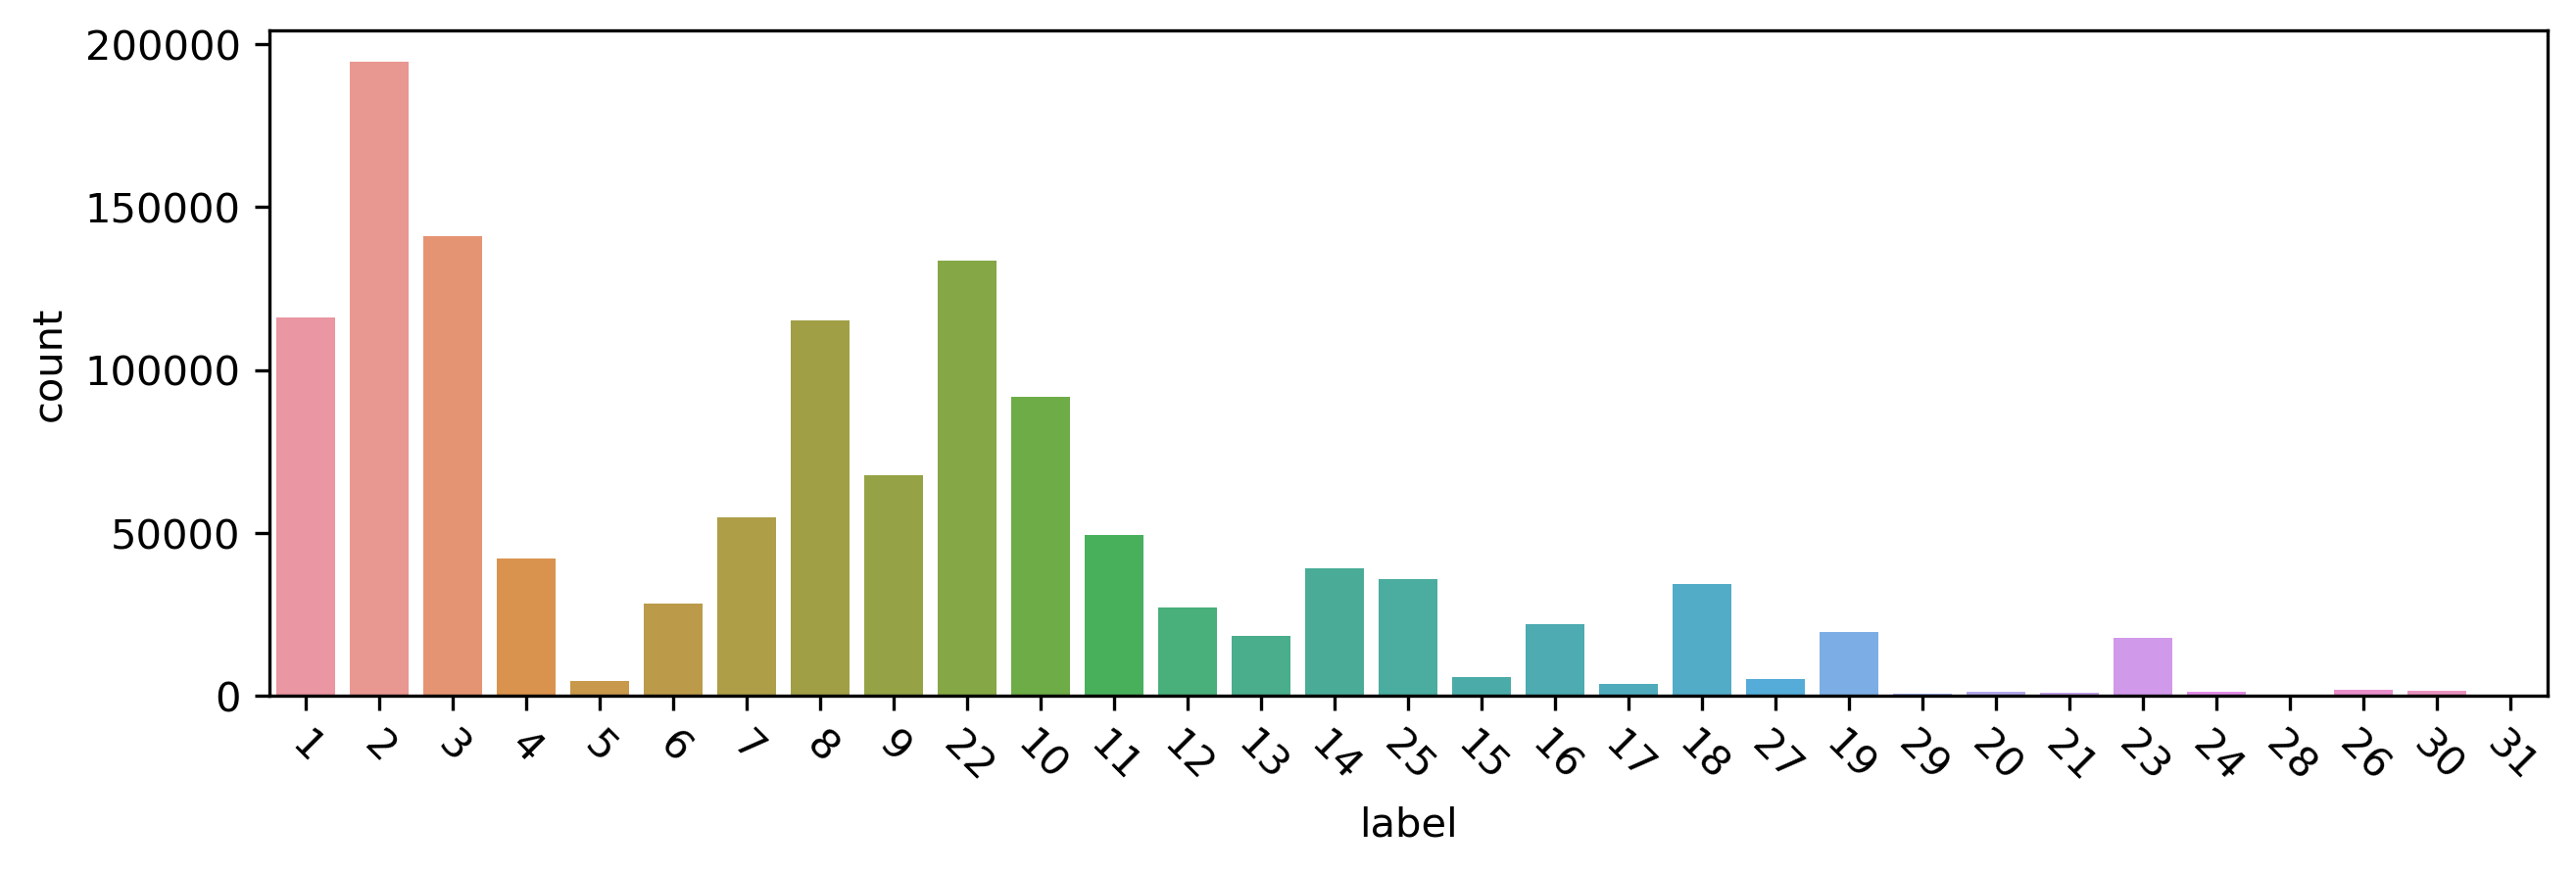

In [67]:
fig, ax = plt.subplots(figsize=(10,3), dpi=300)
sns.countplot(data=df, x='label', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation = -45);

In [68]:
df 

,path,label,duration
0,lb4444_00001_2019_05_21_10_52_58.wav,1,0.037778
1,lb4444_00001_2019_05_21_10_52_58.wav,1,0.040476
2,lb4444_00001_2019_05_21_10_52_58.wav,1,0.037778
3,lb4444_00001_2019_05_21_10_52_58.wav,1,0.040476
4,lb4444_00001_2019_05_21_10_52_58.wav,1,0.037778
...,...,...,...
1278386,lb4444_03928_2019_06_09_16_35_48.wav,26,0.025941
1278387,lb4444_03928_2019_06_09_16_35_48.wav,26,0.026939
1278388,lb4444_03928_2019_06_09_16_35_48.wav,26,0.025941
1278389,lb4444_03928_2019_06_09_16_35_48.wav,26,0.022948


In [72]:
example_annot.seq.segments

(Segment(label='1', onset_s=0.02698412698413, offset_s=0.064761904761912, onset_ind=1295, offset_ind=3109),
 Segment(label='1', onset_s=0.097142857142868, offset_s=0.137619047619063, onset_ind=4663, offset_ind=6606),
 Segment(label='1', onset_s=0.170000000000019, offset_s=0.20777777777780101, onset_ind=8160, offset_ind=9973),
 Segment(label='1', onset_s=0.24285714285717, offset_s=0.283333333333365, onset_ind=11657, offset_ind=13600),
 Segment(label='1', onset_s=0.31571428571432103, offset_s=0.353492063492103, onset_ind=15154, offset_ind=16968),
 Segment(label='1', onset_s=0.391269841269885, offset_s=0.42904761904766703, onset_ind=18781, offset_ind=20594),
 Segment(label='1', onset_s=0.461428571428623, offset_s=0.501904761904818, onset_ind=22149, offset_ind=24091),
 Segment(label='1', onset_s=0.5396825396826, offset_s=0.577460317460382, onset_ind=25905, offset_ind=27718),
 Segment(label='1', onset_s=0.609841269841338, offset_s=0.650317460317533, onset_ind=29272, offset_ind=31215),
 Segm

In [73]:
audseqs[0][1].seq.segments

(Segment(label='7', onset_s=5.232222222222807, offset_s=5.372539682540283, onset_ind=251147, offset_ind=257882),
 Segment(label='7', onset_s=5.380634920635522, offset_s=5.42380952381013, onset_ind=258270, offset_ind=260343),
 Segment(label='7', onset_s=5.431904761905369, offset_s=5.45079365079426, onset_ind=260731, offset_ind=261638),
 Segment(label='7', onset_s=5.458888888889499, offset_s=5.47777777777839, onset_ind=262027, offset_ind=262933),
 Segment(label='7', onset_s=5.485873015873629, offset_s=5.50476190476252, onset_ind=263322, offset_ind=264229),
 Segment(label='7', onset_s=5.512857142857759, offset_s=5.53174603174665, onset_ind=264617, offset_ind=265524),
 Segment(label='7', onset_s=5.539841269841889, offset_s=5.556031746032367, onset_ind=265912, offset_ind=266690),
 Segment(label='7', onset_s=5.566825396826019, offset_s=5.58571428571491, onset_ind=267208, offset_ind=268114),
 Segment(label='7', onset_s=5.593809523810149, offset_s=5.61269841269904, onset_ind=268503, offset_ind

In [75]:
251147 > 693989

False